In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

import torch

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torch.utils.data import  Dataset, TensorDataset, DataLoader

import lib.pytorch_trainer as ptt

from src.imgnet_utils import denormalize

from src.data_loader import _create_dataLoader

from src.Dataset import KaggleSafeDriverDataset

from src.plot_utils import (plot_classes, plot_distribution,
                            statistical_analysis_image, classDistribution,
                            plot_metrics,visualize_predictions,
                            plot_cm_train_valid,plot_layers_weight, plot_confusion, models_comparasion)

from src.extractor_utils import (predict, getPrediction,save_prediction,
                                 load_prediction, torch_summarize)

from src.convnet_models import (MyResNet, MyInception, MyDenseNet)

In [2]:
print("{} GPU's available:".format(torch.cuda.device_count()) )
cpu_count = torch.multiprocessing.cpu_count()
print("\ncpu_count: {}".format(cpu_count))

1 GPU's available:

cpu_count: 8


In [3]:
use_gpu = False
use_DataParalel= False 
use_CPU= False         # http://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html 

if use_gpu:
    if use_DataParalel:
        print("Using DataParalel in all {} GPUS".format(torch.cuda.device_count()))
    else:
        print('Using only one GPU') #{} '.format(device_id))
else:
    print("Using {} CPU's".format(cpu_count))

Using 8 CPU's



# Choose dataset 

In [4]:
path2train = "/home/Prashanth/dl4cv-project/data/train" 

# Images transformation

In [5]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

img_width = img_height=300 #to use InceptionV3 it must img_width and img_height be changed to 300

# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ])
}        

/home/Prashanth/anaconda3/lib/python3.5/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


# Creating  Dataset & Dataloader

In [6]:
batch_size = 32
use_only = 1.0 # Use only is the percentage of the full dataset

In [7]:
dsets = {
    'train': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'], use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'],  is_val=True, use_only=use_only)
}

In [8]:
dset_loaders = _create_dataLoader(dsets, batch_size, pin_memory=False, use_shuffle= False)

# Plotting some examples

torch.Size([3, 300, 300]) torch.Size([32])


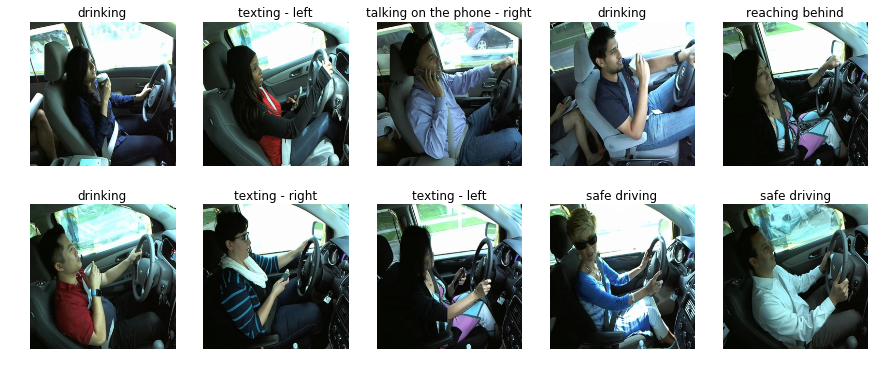

In [9]:
plot_classes(dset_loaders['train'])

### Samples distribution for each class

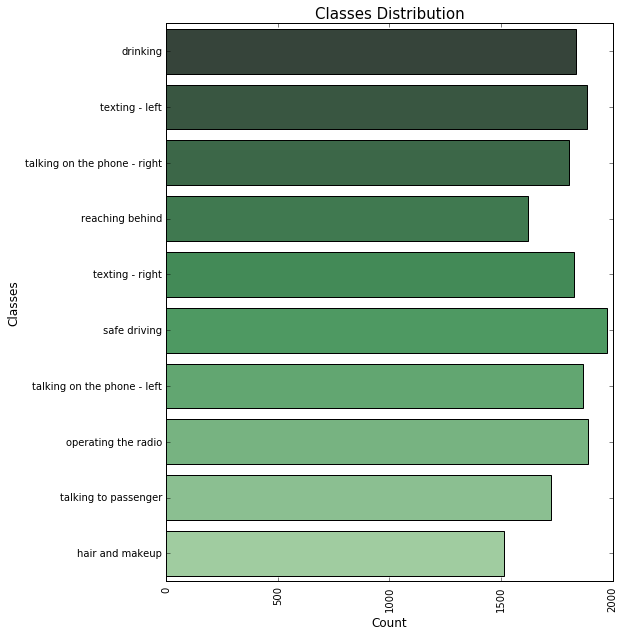

In [10]:
classDistribution(dsets['train'])

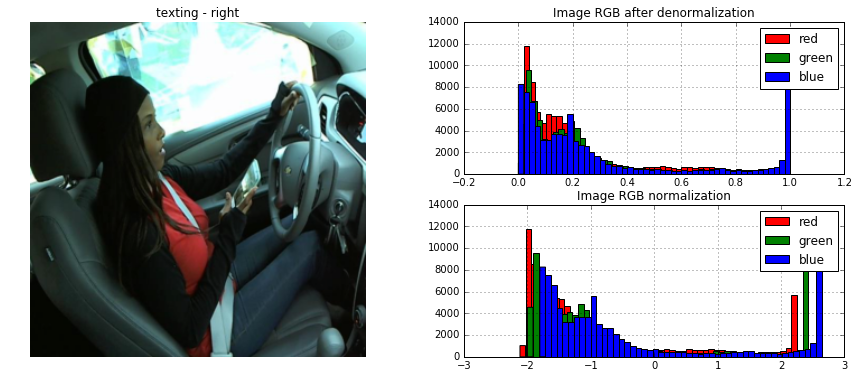

In [11]:
statistical_analysis_image(dset_loaders['train'])

# Choosing Model

In [12]:
use_resnet = False
use_inception = False
use_denseNet = True

if use_resnet:
    print('Using ResNet model')
    model_name = "ResNet"
    model = MyResNet()
elif use_inception:
    print('Using Inception model')
    model_name = "Inception"
    model = MyInception()
elif use_denseNet:
    print('Using DenseNet model')
    model_name = "DenseNet"    
    model = MyDenseNet()

Using DenseNet model


### Plot layers models Weight

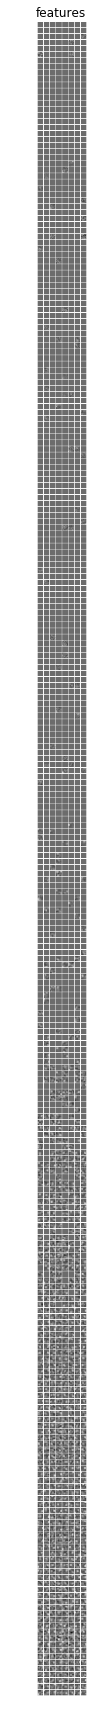

In [13]:
plot_layers_weight(dsets,img_width=img_width, img_height=img_height,conv_model = model.mrnc,use_gpu=use_gpu)

# Mismatch predictions (validation)

In [20]:
model_name = "DenseNetRandomSearch"

In [21]:
path2results = "./results/"

In [22]:
load_results= load_prediction(path2results,model_name)

Loaded features with shapes: 


train:
pred torch.Size([17940, 10]), true torch.Size([17940])

valid:
pred torch.Size([4484, 10]), true torch.Size([4484])

test:
pred torch.Size([79726, 10]), true torch.Size([79726])


In [25]:
from torch.nn.functional import softmax
from torch.autograd import Variable
probas_matrix = torch.nn.functional.softmax(Variable(load_results['valid'][0]))
probas, _ = torch.max(probas_matrix, 1)
probas = probas.data.numpy()

/home/Prashanth/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [26]:
result_valid = {'probas': probas, 'pred': np.argmax(load_results['valid'][0].numpy(), 1), 'true': load_results['valid'][1].numpy()}

In [27]:
i_egal = np.where(result_valid['true'] == result_valid['pred'])[0]
i_not_egal = np.where(result_valid['true'] != result_valid['pred'])[0]

In [28]:
path2saveFigures = './figures/'

### Right predictions with higher probability

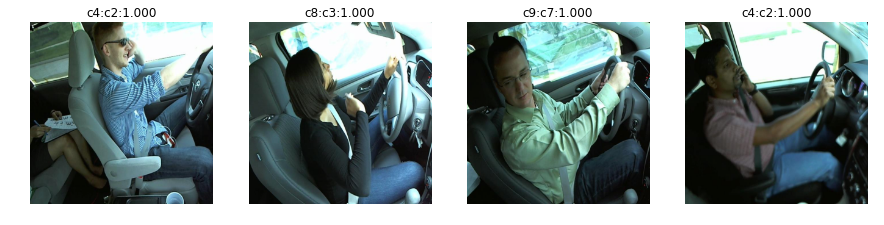

In [29]:
top_predictions = np.argsort(result_valid['probas'][i_egal])[::-1]
y_top = i_egal[top_predictions]

visualize_predictions(dsets['valid'], y_top,  result_valid, path2saveFigures + 'right_higher')

###  Right forecasts with lower probability

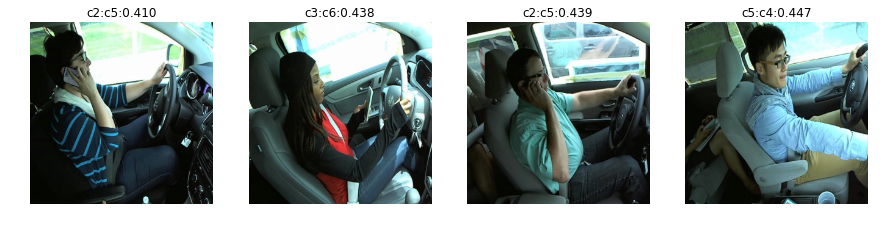

In [30]:
top_predictions = np.argsort(result_valid['probas'][i_egal])
y_bot = i_egal[top_predictions]

visualize_predictions(dsets['valid'],  y_bot, result_valid, path2saveFigures + 'right_lower')

### Wrong forecasts with higher probability

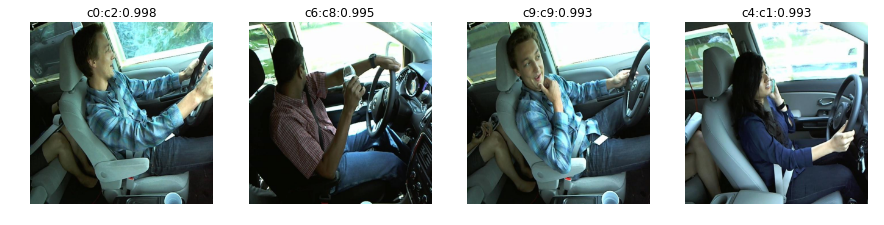

In [31]:
top_predictions = np.argsort(result_valid['probas'][i_not_egal])[::-1]
y_top_not = i_not_egal[top_predictions]

visualize_predictions(dsets['valid'],  y_top_not, result_valid, path2saveFigures + 'wrong_higher')

### Wrong forecasts with lower probability

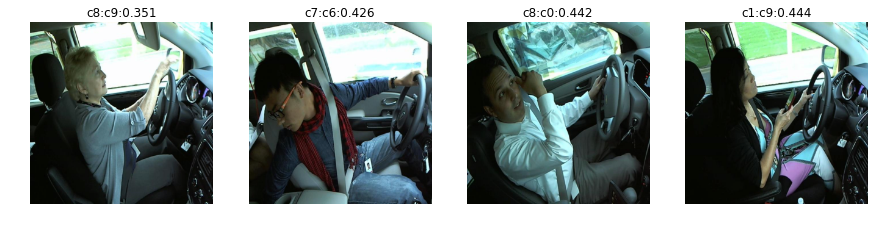

In [32]:
top_predictions = np.argsort(result_valid['probas'][i_not_egal])
y_bot_not = i_not_egal[top_predictions]

visualize_predictions(dsets['valid'],  y_bot_not, result_valid, path2saveFigures + 'wrong_lower')

# Confusion Matrix

In [33]:
results_train = {'pred': np.argmax(load_results['train'][0].numpy(), 1), 'true': load_results['train'][1].numpy()}
results_valid = {'pred': np.argmax(load_results['valid'][0].numpy(), 1), 'true': load_results['valid'][1].numpy()}

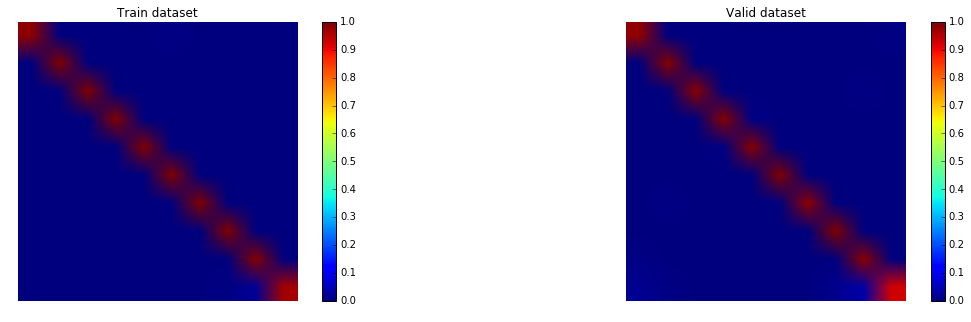

In [34]:
plot_cm_train_valid(results_train, results_valid, path2saveFigures + 'cm')

# Metrics Analysis

In [35]:
path2metrics = './metrics/metrics_'+ model_name+'.csv'

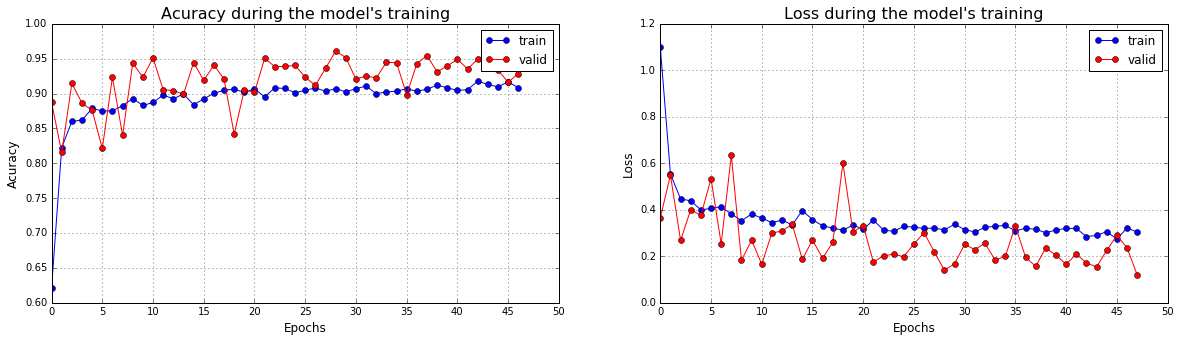

In [36]:
plot_metrics(path2metrics, './figures/results_metrics_'+model_name+'.png')

### Models comparison

In [38]:
models = [ 'Inception', 'DenseNet']
models_comparasion(models, m = 'acc')

OSError: File b'./metrics/metrics_Inception.csv' does not exist